In [1]:
library(ggplot2)
library(stats)
library(dplyr)
library(tidyverse)
suppressPackageStartupMessages(library(circlize))
library(RColorBrewer)
library(paletteer)
library(ComplexHeatmap)
library(circlize)


Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘tidyverse’ was built under R version 4.3.3”
Warning message:
“package ‘tibble’ was built under R version 4.3.3”
Warning message:
“package ‘tidyr’ was built under R version 4.3.3”
Warning message:
“package ‘readr’ was built under R version 4.3.3”
Warning message:
“package ‘purrr’ was built under R version 4.3.3”
Warning message:
“package ‘stringr’ was built under R version 4.3.3”
Warning message:
“package ‘forcats’ was built under R version 4.3.3”
Warning message:
“package ‘lubridate’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     

# Read Data

In [2]:
meta_data <- read.csv("/home//workspace/IHA_Figure_Revision/Figure4/00_Flu_Year_Specific_Meta_Data/meta_data.csv")

In [3]:
df_HAI <- read.csv("/home/workspace/IHA_Figure_Revision/Figure4/01_HAI_MSD_Assay/HAI_Processed.csv")

In [4]:
df_HAI <- df_HAI %>%
    group_by(Assay, Batch) %>%
    mutate(Adjusted_HAI.Mean_Perc_Inhib = Mean_Perc_Inhib - min(Mean_Perc_Inhib) *
        1.00001)
# mutate(Adjusted_HAI.Mean_Perc_Inhib=Mean_Perc_Inhib-min(Mean_Perc_Inhib)/(max(Mean_Perc_Inhib)
# - min(Mean_Perc_Inhib)))

# (df_HAI$Mean_Perc_Inhib - min(df_HAI$Mean_Perc_Inhib)) /
# (max(df_HAI$Mean_Perc_Inhib) -
# min(df_HAI$Mean_Perc_Inhib))

In [5]:
table(df_HAI$Assay, df_HAI$Flu_Year)

              
               2019-2020 2020-2021 2021-2022
  A/Brisbane         117       484       267
  A/Cambodia         117       484       267
  A/Guangdong        117       484       267
  A/HongKong         117       484       267
  A/Kansas           117       484       267
  A/Shanghai         117       484       267
  A/Wisconsin        117       484       267
  B/Phuket           117       484       267
  B/Washington       117       484       267
  BSA                117       484       267

In [6]:
df_HAI <- df_HAI %>%
    mutate(Assay = case_when(
        Assay == "A/Shanghai" ~ "Flu A/Shanghai H7",
        Assay == "A/Brisbane" ~ "Flu A/Brisbane (H1N1)", Assay ==
            "B/Washington" ~ "Flu B/Washington HA", Assay ==
            "B/Phuket" ~ "Flu B/Phuket HA", Assay == "A/HongKong" ~
            "Flu A/Hong Kong H3", TRUE ~ Assay
    ))

In [7]:
table(df_HAI$Assay, df_HAI$Flu_Year)

                       
                        2019-2020 2020-2021 2021-2022
  A/Cambodia                  117       484       267
  A/Guangdong                 117       484       267
  A/Kansas                    117       484       267
  A/Wisconsin                 117       484       267
  BSA                         117       484       267
  Flu A/Brisbane (H1N1)       117       484       267
  Flu A/Hong Kong H3          117       484       267
  Flu A/Shanghai H7           117       484       267
  Flu B/Phuket HA             117       484       267
  Flu B/Washington HA         117       484       267

In [8]:

df_HAI <- df_HAI[c(
    "sample.sampleKitGuid", "Assay", "Mean_Perc_Inhib",
    "Adjusted_HAI.Mean_Perc_Inhib", "cohort.cohortGuid", "subjectGuid",
    "CMV", "Flu_Year", "Flu_Day", "Visit_Type", "Year_N", "Visit_Flu_Year"
)]

In [9]:
colnames(df_HAI)[1:3] <- c("sample.sampleKitGuid", "Assay", "HAI.Mean_Perc_Inhib")

## HAI

In [10]:
df_HAI <- df_HAI %>%
    group_by(subjectGuid, Assay, Flu_Year) %>%
    arrange(Flu_Day) %>%
    dplyr::mutate(across(starts_with("Adjusted_HAI.Mean_Perc_Inhib"),
        ~ . - first(.),
        .names = "DeltaDiff_{col}"
    ))

df_HAI_subset <- df_HAI %>%
    filter(Assay %in% c(
        "A/Guangdong", "A/Cambodia", "Flu B/Phuket HA",
        "Flu B/Washington HA"
    ), Flu_Day == "Day_7", Visit_Type ==
        "FluYear", Flu_Year %in% c("2020-2021", "2021-2022"))

df_HAI_subset <- df_HAI_subset %>%
    filter(!(Assay %in% c("A/Guangdong") && Flu_Year == "2021-2022"))
df_HAI_subset <- df_HAI_subset %>%
    filter(!(Assay %in% c("A/Cambodia") && Flu_Year == "2020-2021"))

In [11]:
df_HAI_subset$donor_flu_year_sample <- paste0(
    df_HAI_subset$subjectGuid,
    "_", df_HAI_subset$Flu_Year, "_", df_HAI_subset$Flu_Day
)

In [12]:
# df_HAI_subset<-df_HAI_subset %>% group_by(Assay) %>%
# mutate(DeltaDiff_Adjusted_HAI.Mean_Perc_Inhib=scale(DeltaDiff_Adjusted_HAI.Mean_Perc_Inhib))
# %>% ungroup()

In [13]:
df_HAI_subset <- df_HAI_subset %>%
    group_by(Assay, Flu_Year) %>%
    mutate(DeltaDiff_Adjusted_HAI.Mean_Perc_Inhib = (DeltaDiff_Adjusted_HAI.Mean_Perc_Inhib -
        median(DeltaDiff_Adjusted_HAI.Mean_Perc_Inhib))/mad(DeltaDiff_Adjusted_HAI.Mean_Perc_Inhib)) %>%
    ungroup()

In [14]:
df_wide <- pivot_wider(
    df_HAI_subset[c(
        "donor_flu_year_sample",
        "DeltaDiff_Adjusted_HAI.Mean_Perc_Inhib", "Assay"
    )],
    names_from = Assay,
    values_from = DeltaDiff_Adjusted_HAI.Mean_Perc_Inhib
) %>%
    as.data.frame()

In [15]:
rownames(df_wide) <- df_wide$donor_flu_year_sample
df_wide <- df_wide %>%
    select(-donor_flu_year_sample)
df_wide <- df_wide[order(rowSums(df_wide, na.rm = TRUE)), ]

In [16]:
mat <- as.matrix(df_wide)

In [17]:
colnames(mat)

[1] "A/Guangdong"         "Flu B/Phuket HA"     "Flu B/Washington HA"
[4] "A/Cambodia"

In [18]:
mat <- mat[, c(
    "Flu B/Phuket HA", "Flu B/Washington HA", "A/Guangdong",
    "A/Cambodia"
)]

In [19]:
row_annot <- as.data.frame(rownames(mat))
parts <- regmatches(rownames(mat), regexec(
    "^(.*?)_(.*?)_(.*)$",
    rownames(mat)
))
row_annot <- as.data.frame(do.call(rbind, parts)[, -1])
row_annot <- left_join(row_annot, unique(meta_data[, c(
    "subjectGuid",
    "subject.biologicalSex", "CMV", "cohort.cohortGuid"
)]), by = c(V1 = "subjectGuid"))

In [20]:
responder_group=read.csv('/home//workspace/IHA_Figure_Revision/Figure4/03_Reponse_Grouping_HAI_MSD/lm_res.csv')

wide_responder_group <- responder_group %>%
  select(subjectGuid, Assay, responder,Flu_Year) %>%
  pivot_wider(names_from = c(Assay), values_from = c("responder"))

In [21]:
row_annot <- left_join(row_annot, wide_responder_group, by = c("V1" = "subjectGuid","V2"="Flu_Year"))

In [22]:
b_cell_changes<-read.csv("/home//workspace/IHA_Figure_Revision//Figure4//05_Bcell_Freq_Changes/freq_changes.csv")
b_cell_changes<-b_cell_changes %>%
    mutate(sample = paste(subject.subjectGuid, Flu_Year)) %>%
    filter(grepl("Plasma", AIFI_L3)) %>%
    select(AIFI_L3, sample, Freq_Fold_Changes_D7_D0) %>%
    pivot_wider(names_from = AIFI_L3, values_from = c("Freq_Fold_Changes_D7_D0")) %>%
    mutate(subjectGuid=substr(sample,1,6),Flu_Year=substr(sample,8,16)) %>% as.data.frame()

In [23]:
row_annot <- left_join(row_annot, b_cell_changes, by = c("V1" = "subjectGuid","V2"="Flu_Year"))

In [24]:
row_annot$V2 <- factor(row_annot$V2, levels = unique(row_annot$V2))

In [25]:
write.csv(row_annot,"row_anno.csv")

In [26]:
write.csv(mat,"mat.csv")

Warning message:
“`convert_length()` only works when aspect of the coordinate is 1.”
Note: 44 points are out of plotting region in sector '2020-2021', track
'5'.

Note: 46 points are out of plotting region in sector '2021-2022', track
'5'.



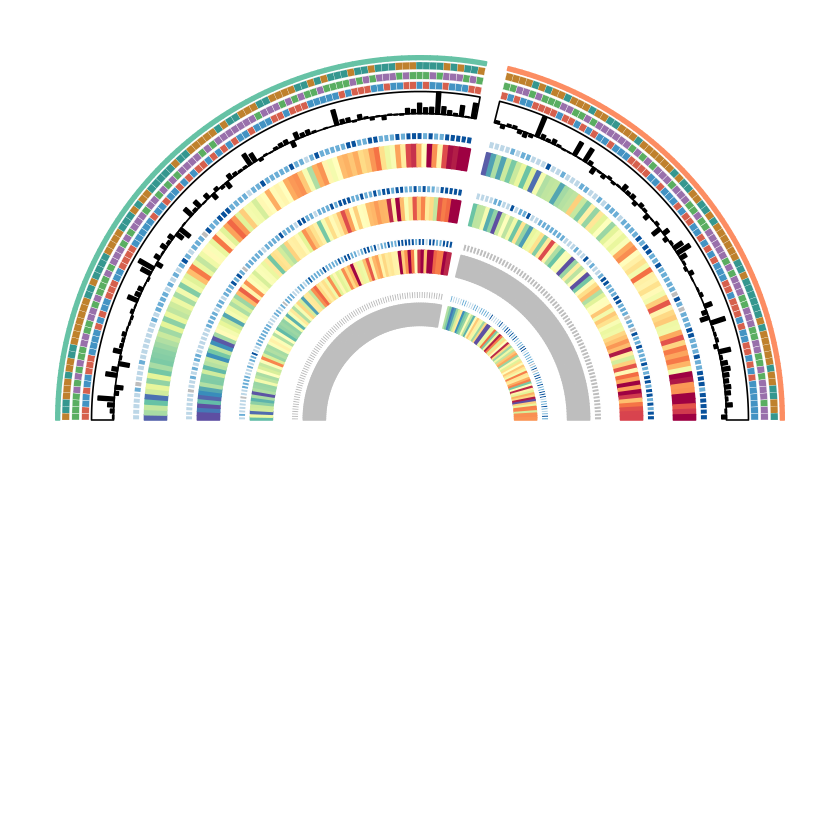

In [27]:
# pdf('circos_plot.pdf', width = 8, height = 8)

circos.clear()
circos.par(track.height = 0.1, start.degree = 180, gap.after = c(3.5, 180))
col_fun1 <- colorRamp2(seq(median(mat[, 1], na.rm = TRUE) - 2 * mad(mat[, 1], na.rm = TRUE), median(mat[, 1], na.rm = TRUE) + 2 * mad(mat[, 1], na.rm = TRUE),
    length.out = 11
), rev(brewer.pal(11, "Spectral")))
col_fun2 <- colorRamp2(seq(median(mat[, 2], na.rm = TRUE) - 2 * mad(mat[, 2], na.rm = TRUE), median(mat[, 2], na.rm = TRUE) + 2 * mad(mat[, 2], na.rm = TRUE),
    length.out = 11
), rev(brewer.pal(11, "Spectral")))
col_fun3 <- colorRamp2(seq(median(mat[, 3], na.rm = TRUE) - 2 * mad(mat[, 3], na.rm = TRUE), median(mat[, 3], na.rm = TRUE) + 2 * mad(mat[, 3], na.rm = TRUE),
    length.out = 11
), rev(brewer.pal(11, "Spectral")))
col_fun4 <- colorRamp2(seq(median(mat[, 4], na.rm = TRUE) - 2 * mad(mat[, 4], na.rm = TRUE), median(mat[, 4], na.rm = TRUE) + 2 * mad(mat[, 4], na.rm = TRUE),
    length.out = 11
), rev(brewer.pal(11, "Spectral")))


set_track_gap(cm_h(0.1))

annotation_levels <- unique(row_annot$V2)
if (length(annotation_levels) < 3) {
    annotation_colors <- setNames(brewer.pal(3, "Set2")[1:length(annotation_levels)], annotation_levels)
} else {
    annotation_colors <- setNames(brewer.pal(length(annotation_levels), "Set2"), annotation_levels)
}
anno_mat <- as.matrix(as.numeric(factor(row_annot$V2, levels = annotation_levels)))
col_fun_anno <- colorRamp2(seq(1, length(annotation_levels)), annotation_colors)
circos.heatmap(anno_mat, col = col_fun_anno, cluster = FALSE, split = row_annot$V2, track.height = 0.01)


annotation_levels <- unique(row_annot$cohort.cohortGuid)
annotation_colors <- c(BR1 = "#35978f", BR2 = "#bf812d")[levels(factor(row_annot$cohort.cohortGuid))]
anno_mat <- as.matrix(as.numeric(factor(row_annot$cohort.cohortGuid)))
col_fun_anno <- colorRamp2(seq(1, length(annotation_levels)), annotation_colors)
circos.heatmap(anno_mat, col = col_fun_anno, cluster = FALSE, cell.border = "white", cell.lwd = 0.1,  track.height = 0.02)

annotation_levels <- unique(row_annot$subject.biologicalSex)
annotation_colors <- c(Male = "#5aae61", Female = "#9970ab")[levels(factor(row_annot$subject.biologicalSex))]
anno_mat <- as.matrix(as.numeric(factor(row_annot$subject.biologicalSex)))
col_fun_anno <- colorRamp2(seq(1, length(annotation_levels)), annotation_colors)
circos.heatmap(anno_mat, col = col_fun_anno, cluster = FALSE, cell.border = "white", cell.lwd = 0.2, track.height = 0.02)

annotation_levels <- unique(row_annot$CMV)
annotation_colors <- c(Positive = "#d6604d", Negative = "#4393c3")[levels(factor(row_annot$CMV))]
anno_mat <- as.matrix(as.numeric(factor(row_annot$CMV)))
col_fun_anno <- colorRamp2(seq(1, length(annotation_levels)), annotation_colors)
circos.heatmap(anno_mat, col = col_fun_anno, cluster = FALSE, cell.border = "white", cell.lwd = 0.2,  track.height = 0.02)


circos.trackPlotRegion(
  factors = row_annot$V2,
  ylim = c(0, max(row_annot$`Plasma cell`, na.rm = TRUE)), 
  track.height = 0.06,
  panel.fun = function(x, y) {
    sector.name <- get.cell.meta.data("sector.index")
    
    idx <- row_annot$V2 == sector.name
    
    x_val <- seq_len(sum(idx)) - 0.5
    
    y_val <- row_annot$`Plasma cell`[idx]
    
    # now draw bars in this sector
    circos.barplot(
      y_val, 
      x_val, 
      col = 'black', 
      border = 'black'
    )
  }
)

set_track_gap(cm_h(0.4))

annotation_colors <- c(`low responder` = "#bdd7e7",`middle responder` = "#6baed6",`high responder` = "#08519c")

annotation_levels <- intersect(unique(row_annot$`Flu B/Phuket HA`), names(annotation_colors))
row_annot$`Flu B/Phuket HA` <- factor(row_annot$`Flu B/Phuket HA`, levels = annotation_levels)
anno_mat <- matrix(as.numeric(row_annot$`Flu B/Phuket HA`))
col_fun_anno <- colorRamp2(seq_along(annotation_levels), annotation_colors[annotation_levels])

circos.heatmap(anno_mat, col = col_fun_anno, cluster = FALSE, cell.border = "white", cell.lwd = 0.8, track.height = 0.02)
set_track_gap(cm_h(0.1))

circos.heatmap(mat[, 1], col = col_fun1, cluster = FALSE, split = row_annot$V2, track.height = 0.06)
set_track_gap(cm_h(0.4))

annotation_levels <- intersect(unique(row_annot$`Flu B/Washington HA`), names(annotation_colors))
row_annot$`Flu B/Washington HA` <- factor(row_annot$`Flu B/Washington HA`, levels = annotation_levels)
anno_mat <- matrix(as.numeric(row_annot$`Flu B/Washington HA`))
col_fun_anno <- colorRamp2(seq_along(annotation_levels), annotation_colors[annotation_levels])

circos.heatmap(anno_mat, col = col_fun_anno, cluster = FALSE, cell.border = "white", cell.lwd = 0.8,  track.height = 0.02)
set_track_gap(cm_h(0.1))

circos.heatmap(mat[, 2], col = col_fun2, cluster = FALSE, split = row_annot$V2, track.height = 0.06)
set_track_gap(cm_h(0.4))

annotation_levels <- intersect(unique(row_annot$`A/Guangdong`), names(annotation_colors))
row_annot$`A/Guangdong` <- factor(row_annot$`A/Guangdong`, levels = annotation_levels)
anno_mat <- matrix(as.numeric(row_annot$`A/Guangdong`))
col_fun_anno <- colorRamp2(seq_along(annotation_levels), annotation_colors[annotation_levels])

circos.heatmap(anno_mat, col = col_fun_anno, cluster = FALSE, cell.border = "white", cell.lwd = 0.8,  track.height = 0.02)
set_track_gap(cm_h(0.1))

circos.heatmap(mat[, 3], col = col_fun3, cluster = FALSE, split = row_annot$V2, track.height = 0.06)
set_track_gap(cm_h(0.4))


annotation_levels <- intersect(unique(row_annot$`A/Cambodia`), names(annotation_colors))
row_annot$`A/Cambodia` <- factor(row_annot$`A/Cambodia`, levels = annotation_levels)
anno_mat <- matrix(as.numeric(row_annot$`A/Cambodia`))
col_fun_anno <- colorRamp2(seq_along(annotation_levels), annotation_colors[annotation_levels])

circos.heatmap(anno_mat, col = col_fun_anno, cluster = FALSE, cell.border = "white", cell.lwd = 0.8,  track.height = 0.02)
set_track_gap(cm_h(0.1))



circos.heatmap(mat[, 4], col = col_fun4, cluster = FALSE, split = row_annot$V2, track.height = 0.06)
set_track_gap(cm_h(0.4))

circos.clear()

# dev.off()


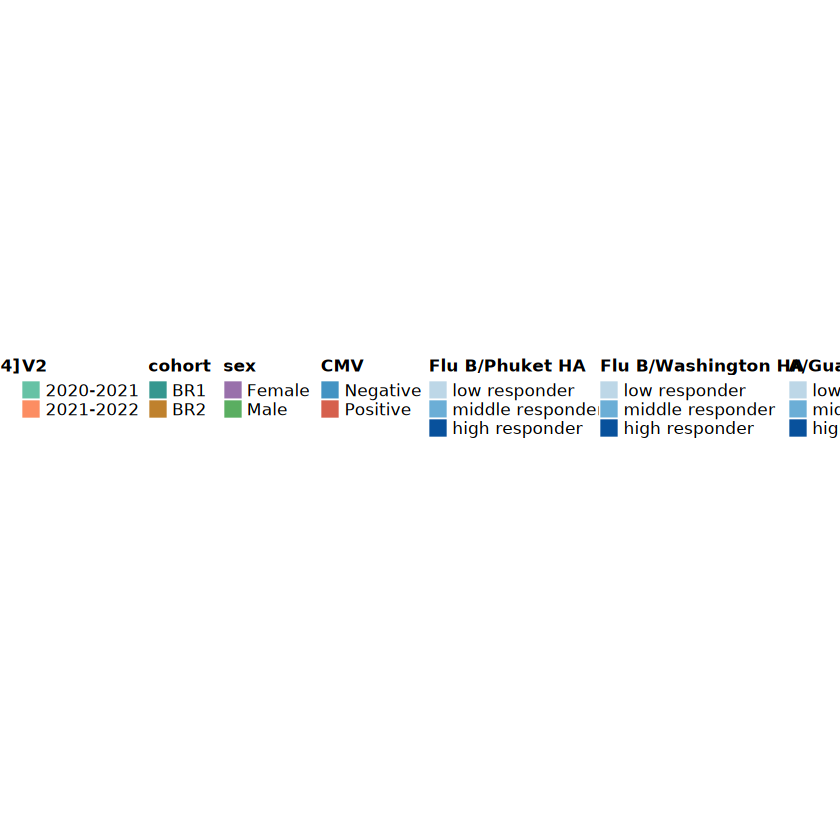

In [28]:


annotation_colors_v2 <- if(length(unique(row_annot$V2)) < 3) {
  setNames(brewer.pal(3, "Set2")[1:length(unique(row_annot$V2))], unique(row_annot$V2))
} else {
  setNames(brewer.pal(length(unique(row_annot$V2)), "Set2"), unique(row_annot$V2))
}
annotation_colors_cohort <- c(BR1 = "#35978f", BR2 = "#bf812d")[levels(factor(row_annot$cohort.cohortGuid))]
annotation_colors_sex <- c(Male = "#5aae61", Female = "#9970ab")[levels(factor(row_annot$subject.biologicalSex))]
annotation_colors_CMV <- c(Positive = "#d6604d", Negative = "#4393c3")[levels(factor(row_annot$CMV))]
annotation_colors_fluPhuket <- annotation_colors[intersect(unique(row_annot$`Flu B/Phuket HA`), names(annotation_colors))]
annotation_colors_fluWash <- annotation_colors[intersect(unique(row_annot$`Flu B/Washington HA`), names(annotation_colors))]
annotation_colors_guangdong <- annotation_colors[intersect(unique(row_annot$`A/Guangdong`), names(annotation_colors))]
annotation_colors_cambodia <- annotation_colors[intersect(unique(row_annot$`A/Cambodia`), names(annotation_colors))]

lgd1 <- Legend(title = "mat[,1]", col_fun = col_fun1)
lgd2 <- Legend(title = "mat[,2]", col_fun = col_fun2)
lgd3 <- Legend(title = "mat[,3]", col_fun = col_fun3)
lgd4 <- Legend(title = "mat[,4]", col_fun = col_fun4)
lgd_v2 <- Legend(title = "V2", at = names(annotation_colors_v2), legend_gp = gpar(fill = annotation_colors_v2))
lgd_cohort <- Legend(title = "cohort", at = names(annotation_colors_cohort), legend_gp = gpar(fill = annotation_colors_cohort))
lgd_sex <- Legend(title = "sex", at = names(annotation_colors_sex), legend_gp = gpar(fill = annotation_colors_sex))
lgd_CMV <- Legend(title = "CMV", at = names(annotation_colors_CMV), legend_gp = gpar(fill = annotation_colors_CMV))
lgd_fluPhuket <- Legend(title = "Flu B/Phuket HA", at = names(annotation_colors_fluPhuket), legend_gp = gpar(fill = annotation_colors_fluPhuket))
lgd_fluWash <- Legend(title = "Flu B/Washington HA", at = names(annotation_colors_fluWash), legend_gp = gpar(fill = annotation_colors_fluWash))
lgd_guangdong <- Legend(title = "A/Guangdong", at = names(annotation_colors_guangdong), legend_gp = gpar(fill = annotation_colors_guangdong))
lgd_cambodia <- Legend(title = "A/Cambodia", at = names(annotation_colors_cambodia), legend_gp = gpar(fill = annotation_colors_cambodia))

all_lgd <- packLegend(lgd1, lgd2, lgd3, lgd4, lgd_v2, lgd_cohort, lgd_sex, lgd_CMV,
                      lgd_fluPhuket, lgd_fluWash, lgd_guangdong, lgd_cambodia,
                      direction = "horizontal")
draw(all_lgd, x = unit(0.5, "npc"), y = unit(0.5, "npc"), just = "center")



In [29]:
pdf("color_palettes.pdf", width = 5, height = 2)
for (pal in paletteer:::c_names) {
    colors <- paletteer_c(pal, n = 11)
    barplot(rep(1, length(colors)),
        col = colors, border = NA,
        main = pal, axes = FALSE
    )
}
dev.off()

pdf 
  2